In [20]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
import csv
import json
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed



# count Samples

In [21]:
file_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/samples.info"

sample_count = 0

with open(file_path, "r") as file:
    for line in file:
        if line.startswith(">"):  # Each sample starts with ">"
            sample_count += 1

print(f"Total number of samples: {sample_count}")

Total number of samples: 2254619


# Generate labels

In [11]:

file_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/samples.info"
NUM_WORKERS = 20  # Adjust based on CPU cores
CHUNK_SIZE = 10**6  # Read file in chunks (adjust as needed)


def process_chunk(chunk_lines):
    """Process a chunk of lines and count occurrences of `sample_SCIENTIFIC_NAME`."""
    local_counter = Counter()
    current_sample = {}

    for line in chunk_lines:
        line = line.strip()
        if line.startswith(">"):  # New sample
            if "sample_SCIENTIFIC_NAME" in current_sample:
                local_counter[current_sample["sample_SCIENTIFIC_NAME"]] += 1
            current_sample = {}  # Reset for new sample

        elif "=" in line:  # Key-value pairs
            key, value = line.split("=", 1)
            if key.strip() == "sample_SCIENTIFIC_NAME":
                current_sample[key.strip()] = value.strip()

    # Add the last processed sample
    if "sample_SCIENTIFIC_NAME" in current_sample:
        local_counter[current_sample["sample_SCIENTIFIC_NAME"]] += 1

    return local_counter

def count_scientific_names_parallel(file_path, num_workers=NUM_WORKERS, chunk_size=CHUNK_SIZE):
    """Reads a large file in parallel and counts occurrences of `sample_SCIENTIFIC_NAME`."""
    total_counter = Counter()
    
    with open(file_path, "r") as file:
        with multiprocessing.Pool(processes=num_workers) as pool:
            while True:
                chunk = list(file.readlines(chunk_size))  # Read a chunk of lines
                if not chunk:
                    break
                results = pool.map(process_chunk, [chunk])  # Process in parallel
                for res in results:
                    total_counter.update(res)  # Merge results

    return total_counter


In [12]:
# Run parallel processing
scientific_name_counts = count_scientific_names_parallel(file_path)

# Convert Counter to DataFrame
df_scientific_counts = pd.DataFrame(scientific_name_counts.items(), columns=["Scientific Name", "Count"])

# Save as variable for future analysis
scientific_name_variable = df_scientific_counts

# Display first few results
display(df_scientific_counts.head())

# Save to CSV if needed
df_scientific_counts.to_csv("scientific_name_counts.csv", index=False)

,Scientific Name,Count
0,Candidatus Nitrosocosmicus sp.,1
1,gut metagenome,120042
2,human metagenome,112328
3,human gut metagenome,277878
4,sludge metagenome,6727


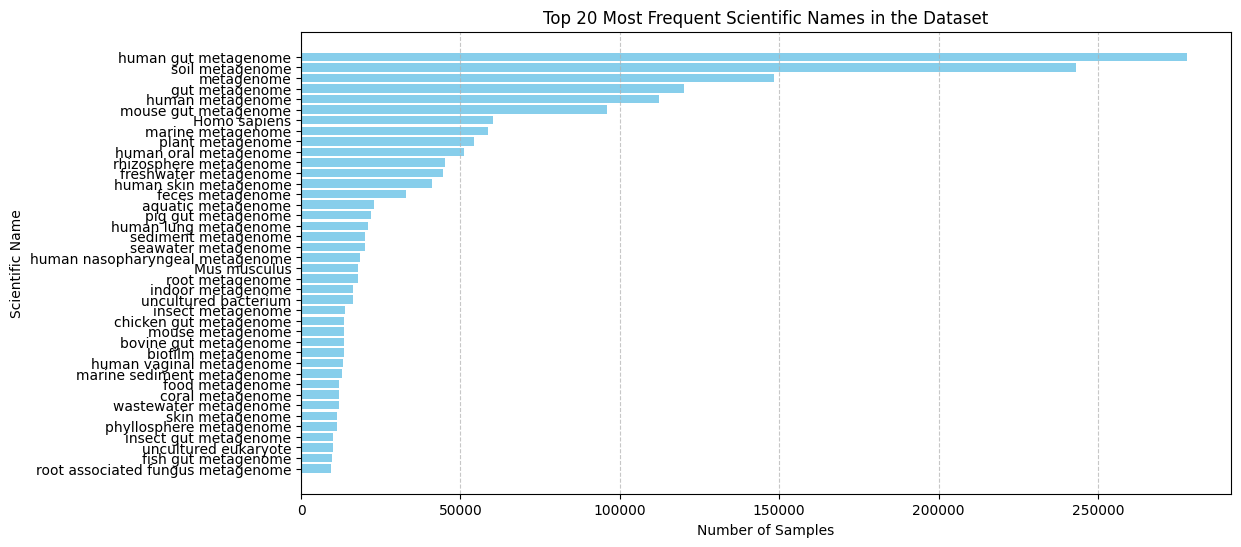

In [9]:

df_top_scientific = df_scientific_counts.sort_values(by="Count", ascending=False).head(40)

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.barh(df_top_scientific["Scientific Name"], df_top_scientific["Count"], color="skyblue")
plt.xlabel("Number of Samples")
plt.ylabel("Scientific Name")
plt.title("Top 20 Most Frequent Scientific Names in the Dataset")
plt.gca().invert_yaxis()  
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show plot
plt.show()

# create dataset, human vs not human

In [22]:
# File path
file_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/samples.info"

# Number of parallel workers
NUM_WORKERS = 4  # Reduce workers for small-scale testing
CHUNK_SIZE = 10**5  # Reduce chunk size for faster testing
MAX_SAMPLES = 2500_000  # Limit number of samples processed

def process_chunk(chunk_lines):
    """Extracts relevant metadata per sample and organizes it into a structured dictionary."""
    sample_data = []
    current_sample = {}
    sample_count = 0

    for line in chunk_lines:
        line = line.strip()

        if line.startswith(">"):  # Start of new sample
            if "sample_SCIENTIFIC_NAME" in current_sample:
                sample_data.append({
                    "Sample ID": current_sample.get("sample_id", "UNKNOWN"),
                    "Scientific Name": current_sample.get("sample_SCIENTIFIC_NAME", "UNKNOWN"),
                    "Study": current_sample.get("study", "UNKNOWN"),
                })
                sample_count += 1
                if sample_count >= MAX_SAMPLES:  # Stop processing after limit
                    break
            
            current_sample = {}  # Reset for new sample
            current_sample["sample_id"] = line[1:].strip()  # Extract Sample ID

        elif "=" in line:  # Key-value pair
            key, value = line.split("=", 1)
            current_sample[key.strip()] = value.strip()

    return sample_data[:MAX_SAMPLES]  # Ensure we return only the limited number

def extract_sample_metadata_parallel(file_path, num_workers=NUM_WORKERS, chunk_size=CHUNK_SIZE, max_samples=MAX_SAMPLES):
    """Reads the file in parallel and extracts relevant sample metadata up to `max_samples`."""
    total_data = []
    processed_samples = 0

    with open(file_path, "r") as file:
        with multiprocessing.Pool(processes=num_workers) as pool:
            while processed_samples < max_samples:
                chunk = list(file.readlines(chunk_size))  # Read chunk
                if not chunk:
                    break

                results = pool.map(process_chunk, [chunk])  
                for res in results:
                    total_data.extend(res)  
                    processed_samples += len(res)
                    if processed_samples >= max_samples:
                        break  # Stop when max samples are reached

    return total_data[:max_samples]  # Ensure the limit is enforced

In [23]:
# Step 1: Extract metadata from a limited portion
sample_metadata = extract_sample_metadata_parallel(file_path)

# Convert to DataFrame
df_samples = pd.DataFrame(sample_metadata)


In [24]:
df_samples.keys()

Index(['Sample ID', 'Scientific Name', 'Study'], dtype='object')

In [52]:
# Step 1: Extract metadata from a limited portion
sample_metadata = extract_sample_metadata_parallel(file_path)

# Convert to DataFrame
df_samples = pd.DataFrame(sample_metadata)

# Step 2: Classify into Human or Non-Human
human_related_terms = ["human", "homo sapiens", "skin", "oral", "vaginal", "nasopharyngeal", "feces", "food fermentation metagenome"]

def classify_metagenome(name):
    """Classifies as 'Human' if it contains relevant terms, else 'Non-Human'."""
    name_lower = name.lower().strip()

    # Exact match check for 'gut metagenome'
    if name_lower == "gut metagenome":
        return "Human"
    
    # Partial match for other terms
    if any(term in name_lower for term in human_related_terms if term != "gut metagenome"):
        return "Human"
    
    return "Non-Human"

df_samples["Category"] = df_samples["Scientific Name"].apply(classify_metagenome)

# Save the processed data (only the limited sample)
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/sample_metadata_limited_100_percent.csv"
df_samples.to_csv(output_path, index=False)

# Display the processed data
print(df_samples.head(20))

     Sample ID                 Scientific Name      Study   Category
0   SRS7471636  Candidatus Nitrosocosmicus sp.  SRP286249  Non-Human
1   ERS2697201                  gut metagenome  ERP010503      Human
2   ERS2756264                human metagenome  ERP105724      Human
3   SRS1490022            human gut metagenome  SRP076119      Human
4    SRS723374                human metagenome  SRP002422      Human
5   SRS2517867               sludge metagenome  SRP117764  Non-Human
6   ERS3462421                    Homo sapiens  ERP104882      Human
7   SRS5092595        mine drainage metagenome  SRP214499  Non-Human
8   SRS5092596        mine drainage metagenome  SRP214499  Non-Human
9   SRS5092597        mine drainage metagenome  SRP214499  Non-Human
10  SRS5092598        mine drainage metagenome  SRP214499  Non-Human
11  SRS5092599        mine drainage metagenome  SRP214499  Non-Human
12  SRS5092600        mine drainage metagenome  SRP214499  Non-Human
13  ERS1475116            uncultur

/tmp/ipykernel_260484/683738382.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="pastel")


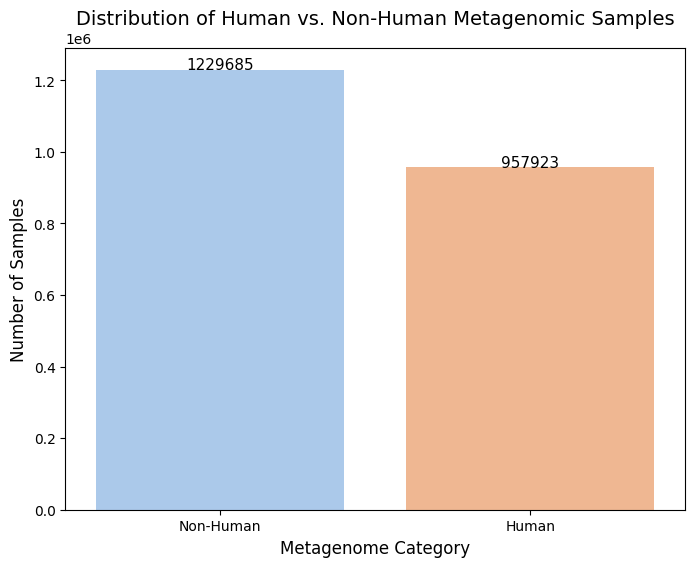

In [45]:
# Count the occurrences of each category
category_counts = df_samples["Category"].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="pastel")

# Labels and title
plt.xlabel("Metagenome Category", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Distribution of Human vs. Non-Human Metagenomic Samples", fontsize=14)

# Show values on top of bars
for i, count in enumerate(category_counts.values):
    plt.text(i, count + 50, str(count), ha="center", fontsize=11)

# Show the plot
plt.show()

# create a dataset with the 10% of data, labeled as human not human

## first i transform the data into .json file

In [1]:
import json
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed


In [2]:
def parse_sample(sample_lines):
    """
    Parse lines for one sample (header + taxonomies).
    Returns (sample_id, {taxonomy_path: abundance, ...}).
    """
    header_line = sample_lines[0].lstrip('>')
    fields = header_line.split()
    sample_id = fields[0]  # e.g. "SRR2459896.SRS1074972"

    tax_dict = {}
    for line in sample_lines[1:]:
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        taxonomy_path = parts[0]
        abundance = int(parts[1])
        tax_dict[taxonomy_path] = abundance

    return sample_id, tax_dict

def stream_samples(file_path):
    """
    Generator that yields a list of lines for each sample.
    Each sample starts with a line beginning '>' and continues
    until the next '>' or EOF.
    """
    with open(file_path, 'r') as f:
        current_sample = []
        for line in f:
            if line.startswith('>'):
                # If we have a prior sample collected, yield it first
                if current_sample:
                    yield current_sample
                # start a new sample
                current_sample = [line.strip()]
            else:
                current_sample.append(line.strip())
        # yield the last sample if it exists
        if current_sample:
            yield current_sample

def main(input_path, output_path, num_workers=4, print_interval=10_000):
    """
    Reads the big file, parses samples in parallel, and writes out a
    single JSON object of the form:

    {
      "sample_id_1": { ... },
      "sample_id_2": { ... },
      ...
    }

    without ever holding the entire data in memory.
    """
    with ProcessPoolExecutor(max_workers=num_workers) as executor, open(output_path, 'w') as out:
        futures = []
        
        # 1) Submit parsing tasks (one per sample)
        for sample_lines in stream_samples(input_path):
            fut = executor.submit(parse_sample, sample_lines)
            futures.append(fut)
        
        # 2) Start writing the JSON file
        out.write("{\n")
        
        first = True      # Track if this is the first sample we write
        processed_count = 0
        
        # 3) As each parse future finishes, write its data immediately
        for fut in as_completed(futures):
            sample_id, tax_dict = fut.result()
            
            # If it's not our first entry, we need a comma+newline before writing the next key
            if not first:
                out.write(",\n")
            first = False
            
            # Write "sample_id": { ... } for each sample
            # e.g.  "SRR2459896.SRS1074972": {"90_15828;96_741;...": 4478, ...}
            out.write(f'"{sample_id}": {json.dumps(tax_dict)}')
            
            # Update progress
            processed_count += 1
            if processed_count % print_interval == 0:
                print(f"Processed {processed_count} samples so far...")
        
        # 4) Close the JSON object
        out.write("\n}\n")

In [3]:

samples_otu_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/samples-otus.99.metag.minfilter"
output_json_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99.json"
main(samples_otu_path, output_json_path, num_workers=35)

Processed 10000 samples so far...
Processed 20000 samples so far...
Processed 30000 samples so far...
Processed 40000 samples so far...
Processed 50000 samples so far...
Processed 60000 samples so far...
Processed 70000 samples so far...
Processed 80000 samples so far...
Processed 90000 samples so far...
Processed 100000 samples so far...
Processed 110000 samples so far...
Processed 120000 samples so far...
Processed 130000 samples so far...
Processed 140000 samples so far...
Processed 150000 samples so far...
Processed 160000 samples so far...
Processed 170000 samples so far...
Processed 180000 samples so far...
Processed 190000 samples so far...
Processed 200000 samples so far...
Processed 210000 samples so far...
Processed 220000 samples so far...
Processed 230000 samples so far...
Processed 240000 samples so far...
Processed 250000 samples so far...
Processed 260000 samples so far...
Processed 270000 samples so far...
Processed 280000 samples so far...
Processed 290000 samples so f

In [5]:
json_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99.json"

with open(json_path, "r") as f:
    data = json.load(f)

# data is now a Python dict with sample_id -> { taxonomy_path: abundance, ... }
print(len(data))  # Number of samples

1836255


In [22]:
# Convert the dictionary keys to a list, then select the first two.
sample_ids = list(data.keys())[:2]

# Print them out
for sample_id in sample_ids:
    print(f"Sample: {sample_id}")
    tax_dict = data[sample_id]

    # tax_dict is a dictionary mapping taxonomy_path -> abundance
    for tax_path, abundance in tax_dict.items():
        print(f"  {tax_path}: {abundance}")

    print()  # extra blank line between samples

Sample: SRR1783668.SRS833580
  90_31;96_56;97_177;98_198;99_232: 49
  90_1007;96_34726;97_44066;98_57634;99_83009: 45
  90_17850;96_69182;97_89870;98_122195;99_188475: 44
  90_801;96_15200;97_23861;98_30156;99_41442: 42
  90_10174;96_44198;97_56604;98_74987;99_110473: 42
  90_16303;96_66488;97_86317;98_117234;99_179668: 42
  90_94;96_1096;97_1284;98_1546;99_1976: 27
  90_459;96_2170;97_2626;98_3256;99_4327: 24
  90_803;96_4042;97_4963;98_6343;99_8685: 23
  90_816;96_22715;97_29698;98_37928;99_95082: 19
  90_1007;96_10510;97_12706;98_15624;99_20677: 18
  90_373;96_35674;97_45309;98_68516;99_100211: 17
  90_1260;96_67485;97_87692;98_119209;99_183073: 15
  90_14742;96_64317;97_83415;98_113059;99_172600: 15
  90_1414;96_6066;97_7292;98_9004;99_11998: 15
  90_969;96_65209;97_84612;98_114771;99_175442: 13
  90_2282;96_10022;97_12092;98_106778;99_162352: 13
  90_6548;96_28854;97_36373;98_47056;99_66694: 12
  90_9151;96_39657;97_50545;98_84029;99_125085: 12
  90_3650;96_24894;97_31181;98_39914

In [ ]:
json_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99.json"

with open(json_path, "r") as f:
    data = json.load(f)


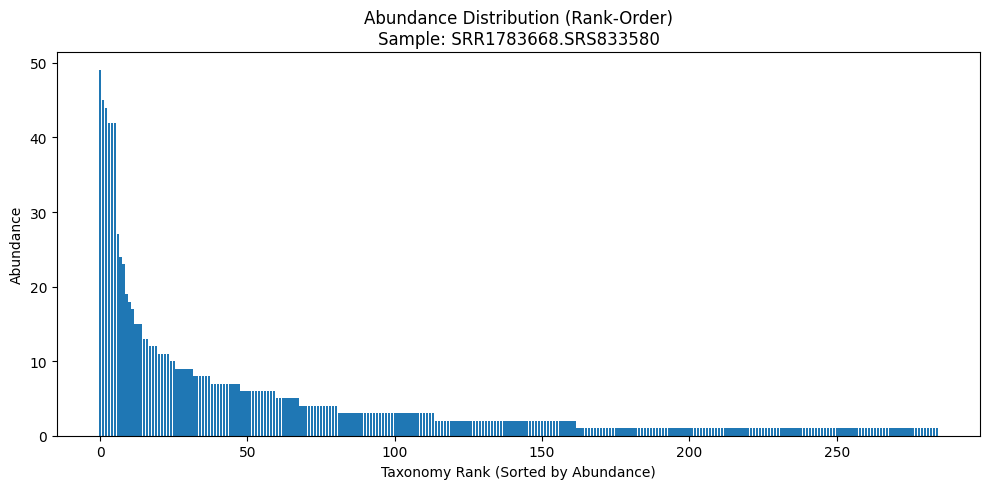

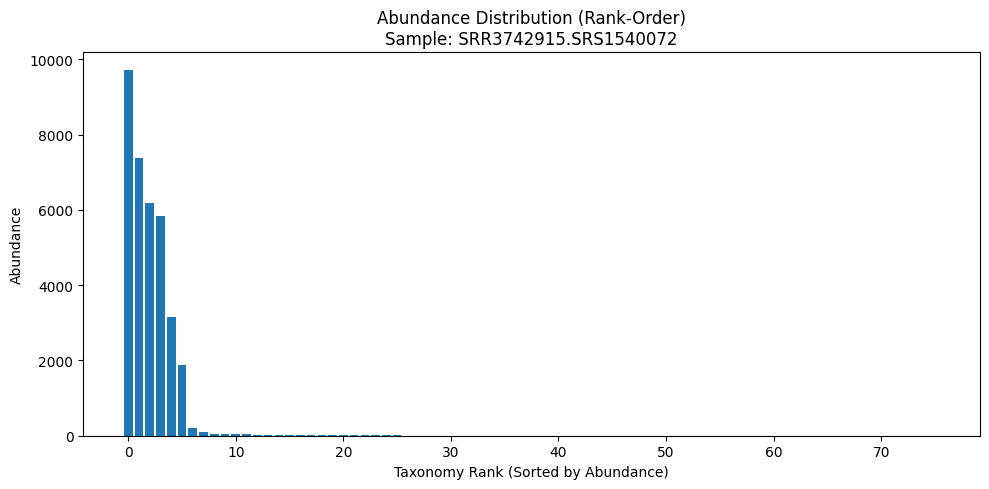

In [57]:
# Grab just the first two sample IDs
sample_ids = list(data.keys())[:2]

for sample_id in sample_ids:
    tax_dict = data[sample_id]

    # Extract and sort the abundance values (descending, for example)
    abundances = list(tax_dict.values())
    abundances.sort(reverse=True)

    # Optional: limit to top 50 if you have a huge number of taxonomies
    # abundances = abundances[:50]

    # Make a bar plot of these sorted abundance values
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(abundances)), abundances)
    plt.title(f"Abundance Distribution (Rank-Order)\nSample: {sample_id}")
    plt.xlabel("Taxonomy Rank (Sorted by Abundance)")
    plt.ylabel("Abundance")
    plt.tight_layout()
    plt.show()

# replace otu code by taxonomy 

In [46]:
# Paths
otu_info_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv"

# Load OTU reference data
otu_df = pd.read_csv(otu_info_path)

# Create a dictionary: OTU ID (replace "_" with ":") → Taxonomy
otu_map = {otu.replace(":", "_"): taxonomy for otu, taxonomy in zip(otu_df["otu_id"], otu_df["taxonomy"])}


sample_count = 0
output_lines = []



In [47]:
def replace_codes_for_first_n_samples(
    samples_json_path,
    code_map,
    output_json_path,
    n=2,
    keep_unmapped=True
):
    """
    Loads the big 'samples_json_path' JSON, but only processes the first N samples.
    Replaces numeric codes with names from the 'code_map_path' JSON, and
    writes out the result to 'output_json_path'.
    """
   
    # 2) Load the big JSON
    with open(samples_json_path, "r") as f:
        big_data = json.load(f)
    
    # 3) Grab first N samples
    sample_ids = list(big_data.keys())[:n]
    
    # 4) Create a dictionary just for those samples
    replaced_data = {}
    for sid in sample_ids:
        tax_dict = big_data[sid]
        new_tax_dict = {}
        for code, abundance in tax_dict.items():
            if code in code_map:
                new_tax_dict[code_map[code]] = abundance
            else:
                if keep_unmapped:
                    new_tax_dict[code] = abundance
        replaced_data[sid] = new_tax_dict
    
    # 5) Write only these first N samples to a new JSON
    with open(output_json_path, "w") as out:
        json.dump(replaced_data, out, indent=2)

In [48]:
samples_json_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99.json"

output_json_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99_first2.json"

replace_codes_for_first_n_samples(samples_json_path, otu_map, output_json_path, n=2)

KeyboardInterrupt: 

In [ ]:
# 2) Load the big JSON
with open(samples_json_path, "r") as f:
	big_data = json.load(f)

# 3) Grab first N samples
sample_ids = list(big_data.keys())[:2]




In [53]:
# 1) Read the CSV into a dictionary
csv_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/sample_metadata_limited_100_percent.csv"

metadata_dict = {}
with open(csv_path, "r", newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        # row["sample_id"] should be something like "SRR1783668"
        srr_key = row["Sample ID"]
        metadata_dict[srr_key] = row  # store the entire row (or just parts if you want)
        

sample_codes =	list(data.keys())[:10]

# 3) For each code, split on '.' to get the base SRR
for full_code in sample_codes:
    base_srr = full_code.split('.')[1]  # e.g. "SRR1783668"
    
    if base_srr in metadata_dict:
        row_info = metadata_dict[base_srr]
        print(f"Found metadata for {full_code} (SRR = {base_srr}):")
        print(row_info)
    else:
        print(f"No metadata found for {full_code} (SRR = {base_srr})")


Found metadata for SRR1783668.SRS833580 (SRR = SRS833580):
{'Sample ID': 'SRS833580', 'Scientific Name': 'bioreactor metagenome', 'Study': 'SRP034704', 'Category': 'Non-Human'}
Found metadata for SRR3742915.SRS1540072 (SRR = SRS1540072):
{'Sample ID': 'SRS1540072', 'Scientific Name': 'silage metagenome', 'Study': 'SRP077887', 'Category': 'Non-Human'}
Found metadata for ERR1371000.ERS1097268 (SRR = ERS1097268):
{'Sample ID': 'ERS1097268', 'Scientific Name': 'Rattus norvegicus albus', 'Study': 'ERP014631', 'Category': 'Non-Human'}
Found metadata for ERR1599214.ERS1311294 (SRR = ERS1311294):
{'Sample ID': 'ERS1311294', 'Scientific Name': 'Homo sapiens', 'Study': 'ERP016515', 'Category': 'Human'}
Found metadata for SRR3053269.SRS1223414 (SRR = SRS1223414):
{'Sample ID': 'SRS1223414', 'Scientific Name': 'human gut metagenome', 'Study': 'SRP067761', 'Category': 'Human'}
Found metadata for ERR1598740.ERS1310820 (SRR = ERS1310820):
{'Sample ID': 'ERS1310820', 'Scientific Name': 'Homo sapiens',

# Clianing 5 % of the taxa abundances 

In [2]:
import ijson
import json
from concurrent.futures import ProcessPoolExecutor, as_completed


In [86]:
def process_sample(sample_id, tax_dict, threshold=5):
    """
    1) Discard any taxa <= 'threshold' reads.
    2) Compute relative abundance from the remaining taxa.
    """
    # Filter out low-abundance taxa
    filtered = {tax: abun for tax, abun in tax_dict.items() if abun > threshold}
    if not filtered:
        return sample_id, {}  # nothing left

    # Sum remaining abundances
    total = sum(filtered.values())

    # Convert to relative
    processed = {}
    for tax, abun in filtered.items():
        processed[tax] = abun / total

    return sample_id, processed


def process_large_json_in_parallel(
    input_json_path,
    output_json_path,
    threshold=5,
    chunk_size=5000,
    num_workers=8
):
    """
    Streams the JSON at 'input_json_path' (a huge dict of sample_id -> {tax->abundance,...}),
    processes each sample in parallel, and writes out a new JSON file with the
    filtered+relative-abundance data.

    - threshold=5  => discard taxa <= 5 reads
    - chunk_size=5000 => process futures in batches to avoid storing too many in memory
    - num_workers=8 => number of parallel processes
    """
    with open(input_json_path, 'r') as fin, open(output_json_path, 'w') as fout:
        # ijson.kvitems(fin, '') will yield (key, value) pairs for each top-level entry
        parser = ijson.kvitems(fin, '')
        # Write the opening brace of our big JSON object
        fout.write("{\n")
        first_sample = True

        # We'll accumulate futures in a list, then collect them in batches
        futures = []
        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            for sample_id, tax_dict in parser:
                # Submit a parallel task to process this one sample
                future = executor.submit(process_sample, sample_id, tax_dict, threshold)
                futures.append(future)

                # Once we reach 'chunk_size' futures, collect them
                if len(futures) >= chunk_size:
                    for fut in as_completed(futures):
                        sid, processed_dict = fut.result()
                        # Write a comma before the next sample if not the first
                        if not first_sample:
                            fout.write(",\n")
                        else:
                            first_sample = False
                        # Write "sample_id": { ... }
                        fout.write(f"\"{sid}\": {json.dumps(processed_dict)}")
                    # Clear the list for the next batch
                    futures.clear()

            # After the loop, handle any remaining futures
            for fut in as_completed(futures):
                sid, processed_dict = fut.result()
                if not first_sample:
                    fout.write(",\n")
                else:
                    first_sample = False
                fout.write(f"\"{sid}\": {json.dumps(processed_dict)}")

        # Close the JSON object
        fout.write("\n}\n")


In [87]:
input_json = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99.json"
output_json = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json"

process_large_json_in_parallel(
	input_json_path=input_json,
	output_json_path=output_json,
	threshold=5,       # Discard taxa <= 5
	chunk_size=5000,   # Tweak for memory / concurrency
	num_workers=30
)

print(f"Done! Wrote filtered JSON to {output_json}")

Done! Wrote filtered JSON to /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json


In [ ]:
output_json = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json"

# 1) Load the full dataset
with open(output_json, "r") as f:
	data = json.load(f)


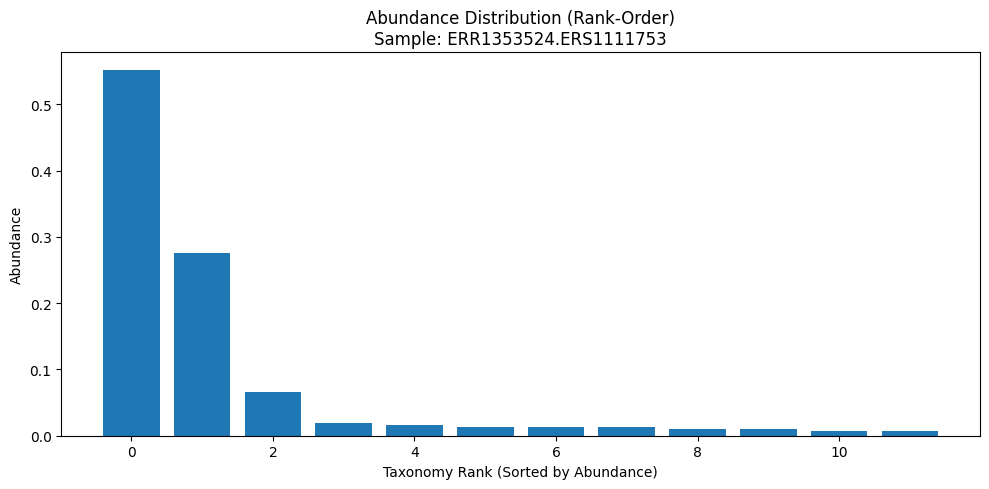

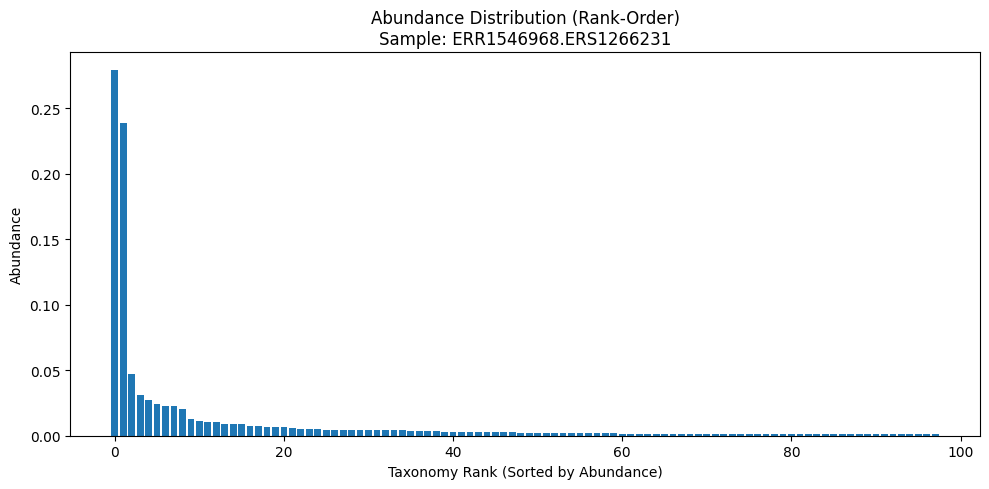

In [8]:
# Grab just the first two sample IDs
sample_ids = list(data.keys())[:2]

for sample_id in sample_ids:
    tax_dict = data[sample_id]

    # Extract and sort the abundance values (descending, for example)
    abundances = list(tax_dict.values())
    abundances.sort(reverse=True)

    # Optional: limit to top 50 if you have a huge number of taxonomies
    # abundances = abundances[:50]

    # Make a bar plot of these sorted abundance values
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(abundances)), abundances)
    plt.title(f"Abundance Distribution (Rank-Order)\nSample: {sample_id}")
    plt.xlabel("Taxonomy Rank (Sorted by Abundance)")
    plt.ylabel("Abundance")
    plt.tight_layout()
    plt.show()

In [13]:
def get_unique_taxa(json_path):
    """
    Streams the JSON file of the form:
      {
        "Sample1": { "TaxA": 0.123, "TaxB": 0.456, ... },
        "Sample2": { ... },
        ...
      }
    And returns how many unique taxa exist in total.
    """
    unique_taxa = set()

    with open(json_path, 'r') as fin:
        # kvitems(fin, '') yields (sample_id, tax_dict) pairs
        parser = ijson.kvitems(fin, '')
        for sample_id, tax_dict in parser:
            # Add all taxon keys from this sample into the set
            for tax_name in tax_dict.keys():
                unique_taxa.add(tax_name)

    return sorted(unique_taxa)


In [14]:
new_dataset_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json"
unique_taxa= get_unique_taxa(new_dataset_path)
print(f"Number of unique taxa in {new_dataset_path}: {len(unique_taxa)}")

Number of unique taxa in /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json: 148615


# build a Samples X Taxa matrix

In [10]:
import scipy.sparse as sp


In [12]:
def build_sparse_matrix(json_path, taxa_list, out_matrix_path,
                        out_samples_path, out_taxa_path, chunk_size=50000):
    """
    Streams the JSON (sample -> {tax -> rel_abun}) and builds a sparse matrix:
       (num_samples x num_taxa).
    We do it in chunks of `chunk_size` samples to avoid huge memory usage.
    """
    taxon_to_col = {tax: i for i, tax in enumerate(taxa_list)}

    blocks = []  # to store each partial block
    sample_ids = []  # all sample IDs in final row order

    # For each chunk, we store coordinates in row_indices, col_indices, data_values
    row_indices = []
    col_indices = []
    data_values = []
    local_row = 0  # row index within the current chunk
    total_samples = 0

    with open(json_path, 'r') as fin:
        parser = ijson.kvitems(fin, '')  # yields (sample_id, {tax->rel_abun})
        for sample_id, tax_dict in parser:
            # Append sample to final row list
            sample_ids.append(sample_id)

            # For each tax present in this sample
            for tax, rel_abun in tax_dict.items():
                # Convert to float just in case
                val = float(rel_abun)
                c = taxon_to_col[tax]  # column index
                row_indices.append(local_row)
                col_indices.append(c)
                data_values.append(val)

            local_row += 1
            total_samples += 1

            # If we have filled a chunk
            if local_row == chunk_size:
                # Build a partial sparse block of shape (this_chunk_size, num_taxa)
                block = sp.coo_matrix(
                    (data_values, (row_indices, col_indices)),
                    shape=(local_row, len(taxa_list))
                ).tocsr()
                blocks.append(block)

                # Reset for the next chunk
                row_indices.clear()
                col_indices.clear()
                data_values.clear()
                local_row = 0

        # After reading all samples, we may have a partial chunk
        if local_row > 0:
            block = sp.coo_matrix(
                (data_values, (row_indices, col_indices)),
                shape=(local_row, len(taxa_list))
            ).tocsr()
            blocks.append(block)

    # Now we vstack all partial blocks into one big sparse matrix
    if blocks:
        sparse_matrix = sp.vstack(blocks, format='csr')
    else:
        # No samples at all?
        sparse_matrix = sp.csr_matrix((0, len(taxa_list)))

    # Save the matrix
    sp.save_npz(out_matrix_path, sparse_matrix)

    # Save sample IDs and taxa
    with open(out_samples_path, 'w') as f:
        for sid in sample_ids:
            f.write(sid + "\n")

    with open(out_taxa_path, 'w') as f:
        for tax in taxa_list:
            f.write(tax + "\n")

    return total_samples


In [25]:
input_json =  "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json"

out_matrix = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz"
out_samples_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_samples.txt"
out_taxa_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa.txt"

# 1) Gather all unique taxa
print("Collecting unique taxa...")
taxa_list = unique_taxa #get_unique_taxa(input_json)
print("Number of unique taxa:", len(taxa_list))

# 2) Build the sparse matrix
print("Building sparse matrix...")
n_samples = build_sparse_matrix(
	json_path=input_json,
	taxa_list=taxa_list,
	out_matrix_path=out_matrix,
	out_samples_path=out_samples_txt,
	out_taxa_path=out_taxa_txt,
	chunk_size=500000,   # adjust based on memory
)
print(f"Done! Created a matrix with {n_samples} rows (samples) and {len(taxa_list)} columns (taxa).")
print(f"Matrix saved to: {out_matrix}")

Number of unique taxa: 148615
Building sparse matrix...
Done! Created a matrix with 1836255 rows (samples) and 148615 columns (taxa).
Matrix saved to: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz


#  Loading the Matrix and Index Files

In [26]:
out_matrix = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz"
samples_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_samples.txt"
taxa_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa.txt"

# Load the sparse matrix
sparse_matrix = sp.load_npz(out_matrix)  # this is a scipy.sparse.csr_matrix, presumably

# Load row -> sample mapping
with open(samples_txt, "r") as f:
    sample_ids = [line.strip() for line in f]

# Load column -> taxon mapping
with open(taxa_txt, "r") as f:
    taxa = [line.strip() for line in f]

print("Matrix shape:", sparse_matrix.shape)
print("Number of samples (rows):", len(sample_ids))
print("Number of taxa (columns):", len(taxa))

Matrix shape: (1836255, 148615)
Number of samples (rows): 1836255
Number of taxa (columns): 148615


In [27]:
# inspect the first sample (row 0)
row_index = 0
sample_id = sample_ids[row_index]

row_vec = sparse_matrix.getrow(row_index)
# row_vec is a 1xN sparse matrix
col_indices = row_vec.indices      # which columns are non-zero
rel_abund_values = row_vec.data    # the corresponding non-zero values

# We can see how many non-zeros there are:
print("Non-zero count:", row_vec.nnz)
print("Sample ID:", sample_id)

# Let's show each (taxon, abundance) pair
for col_idx, abundance in zip(col_indices, rel_abund_values):
    tax_name = taxa[col_idx]
    print(f"{tax_name}: {abundance}")


Non-zero count: 12
Sample ID: ERR1353524.ERS1111753
90_140;96_3341;97_4098;98_5240;99_10961: 0.00641025641025641
90_155;96_519;97_786;98_910;99_1159: 0.01282051282051282
90_16;96_48115;97_61879;98_82395;99_122510: 0.009615384615384616
90_209;96_7520;97_9030;98_11070;99_14620: 0.01282051282051282
90_258;96_3785;97_4666;98_5993;99_8232: 0.01282051282051282
90_273;96_1085;97_1269;98_1524;99_1942: 0.27564102564102566
90_273;96_1085;97_1269;98_1524;99_8086: 0.5512820512820513
90_2;96_2;97_2372;98_20270;99_32480: 0.010683760683760684
90_2;96_60900;97_78871;98_106567;99_161982: 0.06623931623931624
90_34;96_1253;97_2912;98_3629;99_4847: 0.016025641025641024
90_45;96_382;97_430;98_490;99_601: 0.019230769230769232
90_4915;96_22335;97_27905;98_35549;99_49434: 0.00641025641025641


In [28]:
filtered_json_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered.json"

with open(filtered_json_path, "r") as f:
    filtered_data = json.load(f)

# filtered_data is like { "SampleID": { "TaxA": rel_abun, ... }, ... }
expected_dict = filtered_data[sample_id]  # dictionary of {tax -> relative_abundance}

# Let’s compare lengths
print("Matrix row has", row_vec.nnz, "taxa.")
print("JSON has", len(expected_dict), "taxa.")

# Pick one tax from the JSON and compare
for tax, val in expected_dict.items():
    # The matrix’s value:
    #   if that tax is in col_indices, we can retrieve it
    #   otherwise it’s zero (but likely that tax is nonzero, so it should be in col_indices).
    cidx = taxa.index(tax)  # This is O(n) in a simple list. For large lists, a dict is better.
    # But for a quick check, this is fine.
    
    # Extract the matrix’s value from that column. One approach:
    #   we can see if cidx is in col_indices:
    if cidx in col_indices:
        # find the position
        pos = col_indices.tolist().index(cidx)  
        matrix_val = rel_abund_values[pos]
    else:
        matrix_val = 0.0
    
    # print them to compare
    print(f"Tax: {tax}    JSON: {val}    Matrix: {matrix_val}")

Matrix row has 12 taxa.
JSON has 12 taxa.
Tax: 90_273;96_1085;97_1269;98_1524;99_8086    JSON: 0.5512820512820513    Matrix: 0.5512820512820513
Tax: 90_273;96_1085;97_1269;98_1524;99_1942    JSON: 0.27564102564102566    Matrix: 0.27564102564102566
Tax: 90_2;96_60900;97_78871;98_106567;99_161982    JSON: 0.06623931623931624    Matrix: 0.06623931623931624
Tax: 90_45;96_382;97_430;98_490;99_601    JSON: 0.019230769230769232    Matrix: 0.019230769230769232
Tax: 90_34;96_1253;97_2912;98_3629;99_4847    JSON: 0.016025641025641024    Matrix: 0.016025641025641024
Tax: 90_155;96_519;97_786;98_910;99_1159    JSON: 0.01282051282051282    Matrix: 0.01282051282051282
Tax: 90_209;96_7520;97_9030;98_11070;99_14620    JSON: 0.01282051282051282    Matrix: 0.01282051282051282
Tax: 90_258;96_3785;97_4666;98_5993;99_8232    JSON: 0.01282051282051282    Matrix: 0.01282051282051282
Tax: 90_2;96_2;97_2372;98_20270;99_32480    JSON: 0.010683760683760684    Matrix: 0.010683760683760684
Tax: 90_16;96_48115;97_6

# Classification task

In [13]:

matrix_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/samples-otus-99-filtered-matrix.npz"
samples_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_samples.txt"
taxa_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa.txt"


# Load the matrix
X = sp.load_npz(matrix_path)  # shape (N_samples, N_features)

# Load the sample IDs in the same row order
with open(samples_txt, "r") as f:
    sample_ids = [line.strip() for line in f]
    
# Load the taxa names in the same columns order
with open(taxa_txt, "r") as f:
    sample_taxas = [line.strip() for line in f]

print("Matrix shape:", X.shape)
print("Number of rows (samples):", len(sample_ids))
print("Number of columns (taxa):", len(sample_taxas))

Matrix shape: (1836255, 148615)
Number of rows (samples): 1836255
Number of columns (taxa): 148615


In [14]:

# File Paths
taxa_txt = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa.txt"
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv"
output_updated = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa_with_taxonomy.txt"

# 1️⃣ Load OTU Data (Mapping OTU → Taxonomy)
df_otus = pd.read_csv(output_path, usecols=["otu_id", "taxonomy"])  # Load only needed columns
otu_to_taxonomy = dict(zip(df_otus["otu_id"], df_otus["taxonomy"]))  # Create mapping

# 2️⃣ Process `matrix_taxa.txt`
updated_lines = []
with open(taxa_txt, "r") as file:
    for line in file:
        otu_id = line.strip()  # Remove extra spaces/newlines
        taxonomy = otu_to_taxonomy.get(otu_id, "UNKNOWN")  # Lookup taxonomy or set to "UNKNOWN"
        updated_lines.append(f"{otu_id}\t{taxonomy}")

# 3️⃣ Save Updated File
with open(output_updated, "w") as file:
    file.write("\n".join(updated_lines))

print(f"✅ Updated file saved to: {output_updated}")

✅ Updated file saved to: /home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/matrix_taxa_with_taxonomy.txt


In [32]:
metadata_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/sample_metadata_limited_100_percent.csv"
df = pd.read_csv(metadata_path)

# For quicker lookups, make a dictionary: { sample_id_str -> category_str }
label_map = dict(zip(df["Sample ID"], df["Category"]))

print("Metadata rows:", len(df))

Metadata rows: 2187608


In [38]:
sample_ids[0].split('.')[1]


'ERS1111753'

In [ ]:
# Build y as a list
y = []
unmatched_count = 0
not_found = []

for sid in sample_ids:
    sid=sid.split('.')[1]
    if sid in label_map:
        label = label_map[sid]
        y.append(label)
    else:
        # Handle samples that are missing in the CSV
        not_found.append(sid)
        y.append(None)
        unmatched_count += 1

print(f"Created y with length = {len(y)}")
print(f"Unmatched samples (no label found) = {unmatched_count}")

Created y with length = 1836255
Unmatched samples (no label found) = 96060


# tree study

In [8]:

output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv"

# 1) Load the CSV into a DataFrame
df = pd.read_csv(output_path)

df.head()

,otu_id,count,taxonomy,alt_taxonomy,ncbi_ref_id,ref_genome,accession_id,confidence_score,read_count,sec_confidence_score,sec_read_count
0,90_1331;96_6200;97_7452;98_46017;99_90652,2,d__Bacteria;p__Acidobacteriota;c__Blastocatell...,Bacteria;Acidobacteria;Blastocatellia,JF265871:1..1344,GB_GCA_003222245.1~QHVH01000001.1,NC_016024:103114..104617,0.858798,942,0.812454,787
1,90_15782;96_6806;97_8149;98_9996;99_120474,1,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,Bacteria;Actinobacteria;Acidimicrobiia;Acidimi...,KC358213:1..1308,RS_GCF_000350145.1~NZ_BAOL01000001.1,NC_020520:2930699..2932226,0.941131,1149,0.931957,1125
2,90_18593;96_74510;97_96468;98_130600;99_199293,3,d__Bacteria,Eukaryota;Ascomycota;Saccharomycetes;Saccharom...,AY520173:1..1684,RS_GCF_003006845.1~NZ_PXMA01000065.1,AB018123:1..1765,0.917031,191,0.975518,995
3,90_1368;96_28107;97_35403;98_45723;99_64686,1,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteria;Bacteroidetes;Bacteroidia;Bacteroidal...,GU198354:1..1488,RS_GCF_002251535.1~NZ_NPJD01000018.1,NC_014033:223907..225439,0.893145,1155,0.886348,1139
4,90_18;96_298;97_4511;98_47806;99_67852,1,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,Bacteria;Proteobacteria;Gammaproteobacteria;Pa...,HQ717327:1..1300,RS_GCF_000973525.1~NZ_CP004391.1-#4,M75050:1..1479,0.984604,1254,0.976905,1234


In [2]:
#fix nan taxonomies:
"""
Some OTUs did not have a a main taxonomi, "NAN" (36 OTUs), 
in this cases i will select the "alt_taxonomy" as the main taxonomy
"""
import pandas as pd
import numpy as np

In [8]:
output_path = "/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/preprosses_data/processed_otus_info.csv"
df = pd.read_csv(output_path)

# Define the rank codes in the order you'd expect them.
RANK_CODES = ["d", "p", "c", "o", "f", "g", "s"]

def convert_alt_to_ranked_format(alt_tax_str):
    """
    Convert something like: 
       "Bacteria;Firmicutes;Clostridia;Haloplasmatales;Turicibacteraceae;Turicibacter;Turicibacter"
    into:
       "d__Bacteria;p__Firmicutes;c__Clostridia;o__Haloplasmatales;f__Turicibacteraceae;g__Turicibacter;s__Turicibacter"

    If there are fewer than 7 levels, we'll map them in order; 
    if there are more than 7, we'll only take the first 7.

    If 'alt_tax_str' is NaN or empty, return NaN or some placeholder.
    """
    if not isinstance(alt_tax_str, str) or not alt_tax_str.strip():
        # alt_tax_str is NaN, None, or empty
        return np.nan

    parts = alt_tax_str.strip().split(";")
    # Example: ["Bacteria", "Firmicutes", "Clostridia", ...]

    # Build the new format up to min(len(parts), len(RANK_CODES))
    new_parts = []
    for i, rank_name in enumerate(parts):
        if i >= len(RANK_CODES):
            break
        prefix = RANK_CODES[i] + "__"  # "d__", "p__", ...
        new_parts.append(prefix + rank_name.strip())

    # Join them with semicolons
    return ";".join(new_parts)


# 2) Identify rows where 'taxonomy' is NaN
mask = df["taxonomy"].isna()



In [9]:
# 3) For those rows, create the new string from 'alt_taxonomy'
df.loc[mask, "taxonomy"] = df.loc[mask, "alt_taxonomy"].apply(convert_alt_to_ranked_format)

# 4) Optionally, check how many were updated
updated_count = mask.sum()
print(f"{updated_count} rows had NaN in 'taxonomy' and were updated from 'alt_taxonomy'.")

# 5) Save the updated DataFrame back to CSV (if you wish)
df.to_csv(output_path, index=False)

print("Done! The DataFrame now has 'taxonomy' filled in for previous NaN entries.")

55 rows had NaN in 'taxonomy' and were updated from 'alt_taxonomy'.
Done! The DataFrame now has 'taxonomy' filled in for previous NaN entries.
